In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def url(latitude, longitude, angle):
    '''
    Form the full URL to access data via the PVGIS API.
    
    Parameters:
        latitude: {float}
            Latitude of the location in decimal degrees.
        longitude: {float}
            Longitude of the location in decimal degrees.
        angle: {float}
            tilt angle for irradiation.
    Returns:
        {string}
    '''
    
    base_url = 'https://re.jrc.ec.europa.eu/api/v5_2/MRcalc' #The base url to access data via the PVGIS API.

    start_year = 2005 #First year for the desire outcome.
    end_year = 2020 #Final year for the desire outcome.

    parameters = {'lat': latitude,
                  'lon': longitude,
                  'raddatabase': 'PVGIS-ERA5', #Name of the radiation database to be used according to the chosen location.
                  'startyear': start_year,
                  'endyear': end_year,
                  'outputformat': 'csv', #Type of output: comma separated values (csv).
                  'angle': angle,
                  'selectrad': 1, #Output irradiation on plane of selected inclination.
                  'avtemp': 1 #Output monthly average values of daily temperature.
                 }

    query_string = '&'.join([f'{key}={parameters[key]}' for key in parameters]) #Forming the query string.

    full_url = base_url + '?' + query_string #The full url to access data via the PVGIS API.

    return full_url

In [3]:
def optimum_solar_panel_tilt_angle(latitude, longitude, months = "Year"):
    '''
    Get the optimun tilt angle of solar paneles for maximun irradiation in a desired location in specific months.
    
    Parameters:
        latitude: {float}
            Latitude of the location in decimal degrees.
        longitude: {float}
            Longitude of the location in decimal degrees.
        months: {string, list}
            desired months to evaluate solar irradiation, default "Year". Other supported periods are:
                * "S1" : Semester 1.
                * "S2" : Semester 2.
                * "Q1" : Quarter 1.
                * "Q2" : Quarter 2.
                * "Q3" : Quarter 3.
                * "Q4" : Quarter 4.
            Lists must contain among the next string values:
                <"Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec">
    Returns:
        {int}
    '''
    if months == "Year":
        months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    elif months == "S1":
        months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun"]
    elif months == "S2":
        months = ["Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    elif months == "Q1":
        months = ["Jan", "Feb", "Mar"]
    elif months == "Q2":
        months = ["Apr", "May", "Jun"]
    elif months == "Q3":
        months = ["Jul", "Aug", "Sep"]
    elif months == "Q4":
        months = ["Oct", "Nov", "Dec"]
    
    angles = np.arange(0, 91) #Analyze angles from 0° to 90° with a step of 1°.
    
    total_irradiation_at_angles ={}
    
    for angle in angles:
        df = pd.read_csv(url(latitude, longitude, angle), header = 3, skipfooter = 4, sep = '\t\t', engine = 'python')
        df.rename(columns = {"H(i)_m": "montly_irradiation"}, inplace = True)
        df = df[df["month"].isin(months)]
        montly_mean_irradiation = df.groupby('month')["montly_irradiation"].mean()
        total_irradiation = montly_mean_irradiation.sum()
        total_irradiation_at_angles[angle] = total_irradiation
    
    return pd.Series(total_irradiation_at_angles).idxmax()

In [4]:
latitud = ((-6.914086) + (-6.916341))/2 #Latitud del centroide del área de cultivo [°].
print(f"latitud = {round(latitud, 4)}°")
longitud = ((-79.449931) + (-79.451749))/2 #Longitud del centroide del área de cultivo [°].
print(f"longitud = {round(longitud, 4)}°")
datos = pd.read_csv(url(latitud, longitud, 0), header = 3, skipfooter = 4, sep = '\t\t', engine = 'python')
datos.rename(columns = {"H(i)_m": "H_m_0", "T2m": "T_med"}, inplace = True)

meses = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
datos["month"] = pd.Categorical(datos["month"], categories = meses, ordered = True)

datos.head()

latitud = -6.9152°
longitud = -79.4508°


,year,month,H_m_0,T_med
0,2005,Jan,197.39,24.2
1,2005,Feb,146.18,23.5
2,2005,Mar,158.59,23.1
3,2005,Apr,180.41,23.4
4,2005,May,171.70,21.1


In [5]:
resultados = datos.groupby("month")[["H_m_0", "T_med"]].mean()
resultados["days"] = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) #Número de días de cada mes.
resultados["H_d_0"] = resultados["H_m_0"]/resultados["days"]
resultados["H_d_0(mm/day)"] = resultados["H_d_0"] * 1.467
resultados.round(decimals = 3)

,H_m_0,T_med,days,H_d_0,H_d_0(mm/day)
month,,,,,
Jan,180.159,23.550,31,5.812,8.526
Feb,155.923,24.100,28,5.569,8.169
Mar,163.998,24.012,31,5.290,7.761
Apr,167.040,23.106,30,5.568,8.168
May,163.990,21.875,31,5.290,7.760
Jun,152.752,20.512,30,5.092,7.470
Jul,160.342,19.550,31,5.172,7.588
Aug,174.642,19.119,31,5.634,8.265
Sep,181.105,19.362,30,6.037,8.856


In [6]:
resultados["ETo"] = 0.0135 * (resultados["T_med"] + 17.78) * resultados["H_d_0(mm/day)"] #Fórmula de Hargreaves y Samani.

K_c = 0.72 #Coeficiente de cultivo de la palta.
resultados["ETc"] = resultados["ETo"] * K_c
resultados.round(decimals = 3)

,H_m_0,T_med,days,H_d_0,H_d_0(mm/day),ETo,ETc
month,,,,,,,
Jan,180.159,23.550,31,5.812,8.526,4.757,3.425
Feb,155.923,24.100,28,5.569,8.169,4.619,3.325
Mar,163.998,24.012,31,5.290,7.761,4.379,3.153
Apr,167.040,23.106,30,5.568,8.168,4.509,3.246
May,163.990,21.875,31,5.290,7.760,4.154,2.991
Jun,152.752,20.512,30,5.092,7.470,3.861,2.780
Jul,160.342,19.550,31,5.172,7.588,3.824,2.753
Aug,174.642,19.119,31,5.634,8.265,4.117,2.964
Sep,181.105,19.362,30,6.037,8.856,4.441,3.197


In [7]:
eficiencia_riego = 0.90 #Eficiencia del sistema de riego por goteo.
resultados["RR"] = resultados["ETc"]/eficiencia_riego
resultados.round(decimals = 3)

,H_m_0,T_med,days,H_d_0,H_d_0(mm/day),ETo,ETc,RR
month,,,,,,,,
Jan,180.159,23.550,31,5.812,8.526,4.757,3.425,3.806
Feb,155.923,24.100,28,5.569,8.169,4.619,3.325,3.695
Mar,163.998,24.012,31,5.290,7.761,4.379,3.153,3.503
Apr,167.040,23.106,30,5.568,8.168,4.509,3.246,3.607
May,163.990,21.875,31,5.290,7.760,4.154,2.991,3.324
Jun,152.752,20.512,30,5.092,7.470,3.861,2.780,3.089
Jul,160.342,19.550,31,5.172,7.588,3.824,2.753,3.059
Aug,174.642,19.119,31,5.634,8.265,4.117,2.964,3.293
Sep,181.105,19.362,30,6.037,8.856,4.441,3.197,3.553


In [8]:
S_p = 4 #Separación entre plantas [m].
S_s = 6 #Separación entre surcos [m].

resultados["Vol_p"] = resultados["RR"] * S_p * S_s
resultados.round(decimals = 3)

,H_m_0,T_med,days,H_d_0,H_d_0(mm/day),ETo,ETc,RR,Vol_p
month,,,,,,,,,
Jan,180.159,23.550,31,5.812,8.526,4.757,3.425,3.806,91.332
Feb,155.923,24.100,28,5.569,8.169,4.619,3.325,3.695,88.680
Mar,163.998,24.012,31,5.290,7.761,4.379,3.153,3.503,84.070
Apr,167.040,23.106,30,5.568,8.168,4.509,3.246,3.607,86.565
May,163.990,21.875,31,5.290,7.760,4.154,2.991,3.324,79.766
Jun,152.752,20.512,30,5.092,7.470,3.861,2.780,3.089,74.139
Jul,160.342,19.550,31,5.172,7.588,3.824,2.753,3.059,73.419
Aug,174.642,19.119,31,5.634,8.265,4.117,2.964,3.293,79.043
Sep,181.105,19.362,30,6.037,8.856,4.441,3.197,3.553,85.260


In [9]:
Vol_p_max = resultados["Vol_p"].max() #Volumen por planta máximo [l].
N_g_p = 2 #Número de goteros por planta.
Caudal_g = 8 #Caudal del gotero [l/h].
t_r_max = Vol_p_max/(N_g_p * Caudal_g)
print(f"tiempo de riego máximo = {round(t_r_max, 3)} h")

tiempo de riego máximo = 5.943 h


In [10]:
from math import ceil

L_s = 200 #Dimensión de la hectárea a través de la cual se hacen los surcos.
L_p = 50 #Dimensión de la hectárea a lo largo de las plantas en cada surco.

N_s = ceil(L_s/S_s)
print(f'Número de surcos en una hectárea = {N_s}')
N_p = ceil(L_p/S_p)
print(f"úmero de plantas en un surco por hectárea = {N_p}")
N_p_h = N_s * N_p
print(f"Número de plantas por hectárea = {N_p_h}")

Número de surcos en una hectárea = 34
úmero de plantas en un surco por hectárea = 13
Número de plantas por hectárea = 442


In [11]:
resultados["Vol_h"] = resultados["Vol_p"] * N_p_h
resultados.round(decimals = 3)

,H_m_0,T_med,days,H_d_0,H_d_0(mm/day),ETo,ETc,RR,Vol_p,Vol_h
month,,,,,,,,,,
Jan,180.159,23.550,31,5.812,8.526,4.757,3.425,3.806,91.332,40368.857
Feb,155.923,24.100,28,5.569,8.169,4.619,3.325,3.695,88.680,39196.434
Mar,163.998,24.012,31,5.290,7.761,4.379,3.153,3.503,84.070,37158.764
Apr,167.040,23.106,30,5.568,8.168,4.509,3.246,3.607,86.565,38261.667
May,163.990,21.875,31,5.290,7.760,4.154,2.991,3.324,79.766,35256.647
Jun,152.752,20.512,30,5.092,7.470,3.861,2.780,3.089,74.139,32769.242
Jul,160.342,19.550,31,5.172,7.588,3.824,2.753,3.059,73.419,32451.317
Aug,174.642,19.119,31,5.634,8.265,4.117,2.964,3.293,79.043,34937.009
Sep,181.105,19.362,30,6.037,8.856,4.441,3.197,3.553,85.260,37684.929


In [12]:
N_h = 5 #Número de hectáreas.
resultados["Vol_t"] = resultados["Vol_h"] * N_h
resultados["Vol_t(m3/dia)"] = resultados["Vol_t"]/1000
resultados.round(decimals = 3)

,H_m_0,T_med,days,H_d_0,H_d_0(mm/day),ETo,ETc,RR,Vol_p,Vol_h,Vol_t,Vol_t(m3/dia)
month,,,,,,,,,,,,
Jan,180.159,23.550,31,5.812,8.526,4.757,3.425,3.806,91.332,40368.857,201844.284,201.844
Feb,155.923,24.100,28,5.569,8.169,4.619,3.325,3.695,88.680,39196.434,195982.168,195.982
Mar,163.998,24.012,31,5.290,7.761,4.379,3.153,3.503,84.070,37158.764,185793.822,185.794
Apr,167.040,23.106,30,5.568,8.168,4.509,3.246,3.607,86.565,38261.667,191308.335,191.308
May,163.990,21.875,31,5.290,7.760,4.154,2.991,3.324,79.766,35256.647,176283.235,176.283
Jun,152.752,20.512,30,5.092,7.470,3.861,2.780,3.089,74.139,32769.242,163846.210,163.846
Jul,160.342,19.550,31,5.172,7.588,3.824,2.753,3.059,73.419,32451.317,162256.585,162.257
Aug,174.642,19.119,31,5.634,8.265,4.117,2.964,3.293,79.043,34937.009,174685.047,174.685
Sep,181.105,19.362,30,6.037,8.856,4.441,3.197,3.553,85.260,37684.929,188424.644,188.425


In [13]:
Vol_t_max = resultados["Vol_t(m3/dia)"].max()
print(f"Volumen total máximo de riego diario = {round(Vol_t_max, 3)} m3")

D_a = 2 #Días de almacenamiento.
fs = 1.2 #Factor de seguridad.

Vol_emb = Vol_t_max * D_a * fs
print(f"Volumen del embalse = {round(Vol_emb, 3)} m3")

Volumen total máximo de riego diario = 210.146 m3
Volumen del embalse = 504.351 m3


#### Por simplicidad se toma un volumen de embalse igual a 500 m3.

In [14]:
beta_opt = optimum_solar_panel_tilt_angle(latitude = latitud, longitude = longitud)
print(f"Ángulo óptimo para la mayor captación de energía solar anual = {beta_opt}")

Ángulo óptimo para la mayor captación de energía solar anual = 8


#### Tomamos como ángulo de inclinación óptimo 10° ya que éste es el valor mínimo recomendado.

In [15]:
irradiaciones_anuales = {}
angulos = [0, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90] # en [°].
for angulo in angulos:
    datos_anual = pd.read_csv(url(latitud, longitud, angulo), header = 3, skipfooter = 4, sep = '\t\t', engine = 'python')
    datos_anual.rename(columns = {"H(i)_m": "H_m"}, inplace = True)
    irradiacion_por_ano = datos_anual.groupby("year")["H_m"].sum()
    irradiacion_promedio = irradiacion_por_ano.mean()
    irradiaciones_anuales[angulo] = irradiacion_promedio
irradiaciones_anuales = pd.Series(irradiaciones_anuales)
irradiaciones_anuales.round(decimals = 3)

0     2081.428
8     2097.683
10    2097.062
20    2065.838
30    1987.717
40    1864.691
50    1699.815
60    1497.732
70    1266.198
80    1025.600
90     808.339
dtype: float64

In [16]:
beta_opt = 10 #Ángulo de inclinación óptimo seleccionado.
datos_10 = pd.read_csv(url(latitud, longitud, beta_opt), header = 3, skipfooter = 4, sep = '\t\t', engine = 'python')
datos_10.rename(columns = {"H(i)_m": "H_m"}, inplace = True)
meses = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
datos_10["month"] = pd.Categorical(datos_10["month"], categories = meses, ordered = True)
datos_10

,year,month,H_m,T2m
0,2005,Jan,184.49,24.2
1,2005,Feb,141.21,23.5
2,2005,Mar,158.89,23.1
3,2005,Apr,188.40,23.4
4,2005,May,185.65,21.1
...,...,...,...,...
187,2020,Aug,193.53,18.8
188,2020,Sep,192.76,19.3
189,2020,Oct,198.31,20.3
190,2020,Nov,188.25,20.3


In [17]:
irradiacion_10 = datos_10.groupby(["month"])[["H_m"]].mean()
irradiacion_10["days"] = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) #Número de días de cada mes.
irradiacion_10["H_d"] = irradiacion_10["H_m"]/irradiacion_10["days"]
irradiacion_10["HSP"] = irradiacion_10["H_d"]/1
irradiacion_10.round(decimals = 3)

,H_m,days,H_d,HSP
month,,,,
Jan,168.979,31,5.451,5.451
Feb,150.778,28,5.385,5.385
Mar,164.026,31,5.291,5.291
Apr,174.005,30,5.800,5.800
May,176.954,31,5.708,5.708
Jun,167.651,30,5.588,5.588
Jul,174.518,31,5.630,5.630
Aug,184.549,31,5.953,5.953
Sep,184.101,30,6.137,6.137


In [18]:
caudal_bomba_mes = resultados["Vol_t(m3/dia)"]/irradiacion_10["HSP"]
caudal_bomba_mes.round(decimals = 3)

month
Jan    37.029
Feb    36.395
Mar    35.114
Apr    32.983
May    30.882
Jun    29.319
Jul    28.822
Aug    29.343
Sep    30.705
Oct    32.342
Nov    34.231
Dec    36.018
dtype: float64

In [19]:
fs = 1.3 #Factor de seguridad.
Caudal_bomba = caudal_bomba_mes.max() * fs
print(f"Caudal de la bomba = {Caudal_bomba:.3f} m3/h")

Caudal de la bomba = 48.138 m3/h


#### Por simplicidad se toma un caudal de bombeo de 48 m3/h.

In [20]:
L_lat = 250 #Longitud del lateral [m].
N_p_lat = ceil(L_lat/S_p) #Número de plantas en un lateral.
print(f"Número de plantas en la tubería lateral = {N_p_lat}")
Caudal_lat = N_p_lat * N_g_p * Caudal_g
print(f"Caudal en el inicio del lateral = {Caudal_lat} l/h")
L_f = 1.2 * L_lat
print(f"Longitud ficticia del lateral = {L_f} m")

Número de plantas en la tubería lateral = 63
Caudal en el inicio del lateral = 1008 l/h
Longitud ficticia del lateral = 300.0 m


In [21]:
v_lat = 1.5 #Velocidad máxima en el lateral [m/s].
D_lat = 0.5947*(Caudal_lat/v_lat)**0.5
print(f"Diámetro del lateral = {round(D_lat, 3)} mm")

Diámetro del lateral = 15.416 mm


#### Se elige una tubería comercial que presente un diámetro interior mayor. En este caso se selecciona una tubería de polietileno de 4 Bar con 32 mm de diámetro nominal, el cual presenta un diámetro interior de 28 mm.

In [22]:
D_lat = 28 #Diámetro interior de la tubería lateral seleccionada [mm].
F_c = 0.372 #Factor de Christiansen.
h_L_lat = 0.496 * (Caudal_lat**1.75) * F_c * L_f/(D_lat**4.75)
print(f"Pérdida de carga en el lateral = {h_L_lat:.3f} m")

Pérdida de carga en el lateral = 1.334 m


In [23]:
L_pl = 100 #Longitud del portalateral [m].
N_lat_pl = ceil(L_pl/S_s)
print(f"Número de laterales por portalateral = {N_lat_pl}")

Número de laterales por portalateral = 17


In [24]:
Caudal_pl = N_lat_pl * Caudal_lat
print(f"Caudal en el origen del portalateral = {Caudal_pl} l/h")

Caudal en el origen del portalateral = 17136 l/h


In [25]:
L_f = 1.2 * L_pl
print(f"Longitud ficticia del portalateral = {L_f} m")

Longitud ficticia del portalateral = 120.0 m


In [26]:
v_pl = 2.5 #Velocidad máxima en el portalateral [m/s].
D_pl = 0.5947*(Caudal_pl/v_pl)**0.5
print(f"Diámetro del portalateral = {round(D_pl, 3)} mm")

Diámetro del portalateral = 49.236 mm


#### Se elige una tubería comercial que presente un diámetro interior mayor. En este caso se selecciona una tubería comercial de PVC de 5 Bar con 2” de diámetro nominal, el cual presenta un diámetro interior de 56.4 mm.

In [27]:
D_pl = 56.4 #Diámetro interno del portalateral seleccionado [mm].
F_c = 0.393 #Factor de Christiansen.
h_L_pl = 0.496 * (Caudal_pl**1.75) * F_c * L_f/(D_pl**4.75)
print(f"Pérdida de carga en el portalateral = {h_L_pl:.3f} m")

Pérdida de carga en el portalateral = 2.883 m


#### El rango de presión del gotero compensante seleccionado para un adecuado funcionamiento está entre 5 mca y 40 mca. Entonces, podemos establecer la siguiente presión mínima en las subunidades de riego: 9 mca.

In [28]:
P_min_su = 9 #presión mínima en la subunidad [mca].
P_ini_pl = P_min_su + h_L_pl
print(f"Presión necesaria en el origen del portalateral = {round(P_ini_pl, 3)} mca")

Presión necesaria en el origen del portalateral = 11.883 mca


In [29]:
Z_ini_lat = 144 #Cota del inicio del lateral [msnm].
Z_fin_lat = 138 #Cota del final del lateral [msnm].
P_max_su = P_ini_pl - h_L_lat + (Z_ini_lat - Z_fin_lat)
print(f"Presión máxima en la subunidad = {round(P_max_su, 3)} mca")

Presión máxima en la subunidad = 16.549 mca


In [30]:
N_sec = 2 #Número de tuberías secundarias (en este caso es igual al número de portalaterales).
Caudal_pri = N_sec * Caudal_pl
print(f"Caudal en la primaria = {Caudal_pri} l/h")

Caudal en la primaria = 34272 l/h


In [31]:
v_pri = 2.5 #Velocidad máxima en la primaria [m/s].
D_pri = 0.5947 * np.sqrt(Caudal_pri/v_pri)
print(f"Diámetro de la primaria = {round(D_pri, 3)} mm")

Diámetro de la primaria = 69.63 mm


#### Se elige una tubería comercial que presente un diámetro interior mayor. En este caso se selecciona una tubería comercial de PVC de 5 Bar con 4” de diámetro nominal, el cual presenta un diámetro interior de 108.4 mm.

In [32]:
D_pri = 108.4 #Diámetro interno de la tubería primaria seleccionada [mm].
L_pri = 380 #Longitud de la primaria [m].
L_f = 1.15 * L_pri
print(f"Longitud ficticia de la primaria = {L_f} m")

Longitud ficticia de la primaria = 436.99999999999994 m


In [33]:
h_L_pri = (0.496 * (Caudal_pri**1.75) * L_f)/(D_pri**4.75)
print(f"Pérdida de carga en la primaria = {h_L_pri:.3f} m")

Pérdida de carga en la primaria = 4.034 m


In [34]:
P_ini_pri = 0 #Consideramos el caso extremo cuando el embalse está con poco nivel de agua.
Z_ini_pri = 160 #Cota del inicio de la primaria [msnm].
Z_fin_pri = 144 #Cota del final de la primaria [msnm].
P_fin_pri = P_ini_pri - h_L_pri + (Z_ini_pri - Z_fin_pri)
P_ini_pl = P_fin_pri
print(f"Presión en el inicio del portalateral = {round(P_ini_pl, 3)} mca")

Presión en el inicio del portalateral = 11.966 mca


#### El resultado anterior indica que aún en la condición extrema en la cual el embalse se está vaciando, se tiene una presión garantizada en el inicio de la tubería portalateral de casi 12 mca. Este resultado está acorde con los 11.883 mca de presión necesaria al inicio de la tubería portalateral calculada anteriormente. Por lo tanto, el punto seleccionado como extremo superior de la tubería primaria es adecuado.

In [35]:
v_imp = 2.5 #Velocidad máxima en la tubería de impulsión [m/s].
Caudal_bomba = 48000 #Caudal de la bomba [l/h].
D_imp = 0.5947 * np.sqrt(Caudal_bomba/v_imp)
print(f"Diámetro de la tubería de impulsión = {round(D_imp, 3)} mm")

Diámetro de la tubería de impulsión = 82.404 mm


#### Se elige una tubería comercial que presente un diámetro interior mayor. En este caso, se debe elegir una tubería con una presión nominal adecuada que soporte la presión a la salida de la bomba. El cálculo de la presión a la salida de la bomba se determina posteriormente. Se opta por seleccionar una tubería comercial de PVC de 10 Bar con 4” de diámetro nominal, el cual presenta un diámetro interior de 103.2 mm.

In [36]:
D_imp = 0.1032 #Diámetro interno de la tubería de impulsión seleccionada [m].
v_imp = (Caudal_bomba/(1000*3600))/((np.pi/4)*(D_imp**2))
print(f"Velocidad real en la tubería de impulsión = {round(v_imp, 3)} m/s")

Velocidad real en la tubería de impulsión = 1.594 m/s


In [37]:
#Considerando la temperatura del fluido bombeado en 20 °C, se tienen las siguientes propiedades:
rho = 998 #Densidad del agua [kg/m3].
mu = 1.002e-3 #Viscocidad dinámica del agua [kg/m-s].

In [38]:
Re = rho * v_imp * D_imp / mu
print(f"Número de Reynolds = {round(Re, 3)}")

Número de Reynolds = 163844.542


#### Como Re > 4000 se tiene un flujo turbulento y el factor de fricción para flujo turbulento se determina con la ecuación de Colebrook.

In [39]:
import colebrook

epsilon = 3e-7 #Rugosidad absoluta del PVC.

f = colebrook.sjFriction(Re, epsilon/D_imp)
print(f"Factor de fricción = {round(f, 4)}")

Factor de fricción = 0.0162


In [40]:
L_imp = 800 #Longitud de la tubería de impulsión [m].
g = 9.81 #Aceleración de la gravedad [m/s2].
h_L_friccion = f *(L_imp/D_imp)*(v_imp**2/(2*g))
print(f"Pérdida de carga por fricción en la tubería de impulsión = {round(h_L_friccion, 3)} m")

Pérdida de carga por fricción en la tubería de impulsión = 16.263 m


In [41]:
Relacion_Longitud_equiv_cod = 30 #Relación de longitud equivalente para un codo estándar de 90°.
n_cod = 4 #Número de codos.
h_L_cod = n_cod * f * Relacion_Longitud_equiv_cod * (v_imp**2)/(2*g)
print(f"Pérdida de carga en los codos = {round(h_L_cod, 3)} m")

Pérdida de carga en los codos = 0.252 m


In [42]:
Relacion_Longitud_equiv_com = 8 #Relación de longitud equivalente para una válvula de compuerta totalmente abierta.
n_com = 1 #Número de válvulas de compuerta.
h_L_com = n_com * f * Relacion_Longitud_equiv_com * (v_imp**2)/(2*g)
print(f"Pérdida de carga en la válvula de compuerta = {round(h_L_com, 3)} m")

Pérdida de carga en la válvula de compuerta = 0.017 m


In [43]:
Relacion_Longitud_equiv_ret = 150 #Relación de longitud equivalente para una válvula de retención.
n_ret = 1 #Número de válvulas de retención.
h_L_ret = n_ret * f * Relacion_Longitud_equiv_ret * (v_imp**2)/(2*g)
print(f"Pérdida de carga en la válvula de retención = {round(h_L_ret, 3)} m")

Pérdida de carga en la válvula de retención = 0.315 m


In [44]:
h_L_menores = h_L_cod + h_L_com + h_L_ret
print(f"Pérdidas de carga menores = {round(h_L_menores, 3)} m")

Pérdidas de carga menores = 0.583 m


In [45]:
h_L = h_L_friccion + h_L_menores
print(f"Pérdida de carga total = {round(h_L, 3)} m")

Pérdida de carga total = 16.846 m


In [46]:
v_a = 0 #Velocidad en el punto a.
Z_a = 108 #Cota del punto a [msnm].
P_a = 0 #Presión en el punto a.

v_b = v_imp #Velocidad en el punto b.
Z_b = 162.5 #Cota del punto b [msnm].
P_b = 0 #Presión en el punto b.

h_bomba = P_b/(rho*g) + (v_b**2)/(2*g) + Z_b + h_L - P_a/(rho*g) - (v_a**2)/(2*g) - Z_a
print(f"Carga total de la bomba = {round(h_bomba, 3)} m")

Carga total de la bomba = 71.476 m


In [47]:
v_s = v_imp #Velocidad en el punto s.
Z_s = 106.5 #Cota del punto s [msnm].
h_L_aYs = 0 #Pérdida de carga entre los puntos a y s.

P_s = rho * g * (h_bomba + P_a/(rho*g) + (v_a**2)/(2*g) + Z_a - (v_s**2)/(2*g) - Z_s - h_L_aYs)
print(f"Presión en la salida de la bomba = {round(P_s, 3)} Pa")

Presión en la salida de la bomba = 713193.944 Pa


In [48]:
import colebrook
Caudales_bomba = np.array([50, 100, 150, 200, 250, 300]) #en GMP.

Reynolds = {}
factores_friccion = {}
perdidas_carga = {}
Alturas_bomba_sistema = {}
for caudal_bomba in Caudales_bomba:
    v_imp = (4/np.pi)*(caudal_bomba*6.30901964e-5)/(D_imp**2) #En m/s.
    
    Re = rho * v_imp * D_imp/mu
    Reynolds[caudal_bomba] = Re
    
    f = colebrook.sjFriction(Re, epsilon/D_imp)
    factores_friccion[caudal_bomba] = f
    
    h_L_friccion = f * (L_imp/D_imp) * ((v_imp**2)/(2*g))
    h_L_cod = n_cod * f * Relacion_Longitud_equiv_cod * ((v_imp**2)/(2*g))
    h_L_com = 1 * f * Relacion_Longitud_equiv_com * ((v_imp**2)/(2*g))
    h_L_ret = 1 * f * Relacion_Longitud_equiv_ret * ((v_imp**2)/(2*g))
    h_L_menores = h_L_cod + h_L_com + h_L_ret
    h_L = h_L_friccion + h_L_menores
    perdidas_carga[caudal_bomba] = h_L
    
    h_bomba = P_b/(rho*g) + (v_b**2)/(2*g) + Z_b + h_L - P_a/(rho*g) - (v_a**2)/(2*g) - Z_a
    Alturas_bomba_sistema[caudal_bomba] = round(h_bomba*3.2808398950131, 3) #En pies.

In [49]:
Alturas_bomba_sistema = pd.Series(Alturas_bomba_sistema)
Alturas_bomba_sistema

50     183.432
100    193.668
150    208.965
200    229.341
250    254.186
300    283.042
dtype: float64

In [50]:
Alturas_bomba_6PWS230G150 = {50: 320, 100: 300, 150: 265, 200: 238, 250: 200, 300: 145} #Del catálogo de bombas.
Alturas_bomba_6PWS230G150 = pd.Series(Alturas_bomba_6PWS230G150)
Alturas_bomba_6PWS230G150

50     320
100    300
150    265
200    238
250    200
300    145
dtype: int64

C:\Users\josie\anaconda3\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\josie\anaconda3\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\josie\anaconda3\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\josie\anaconda3\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\josie\anaconda3\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\josie\anaconda3\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\josie\anaconda3\lib

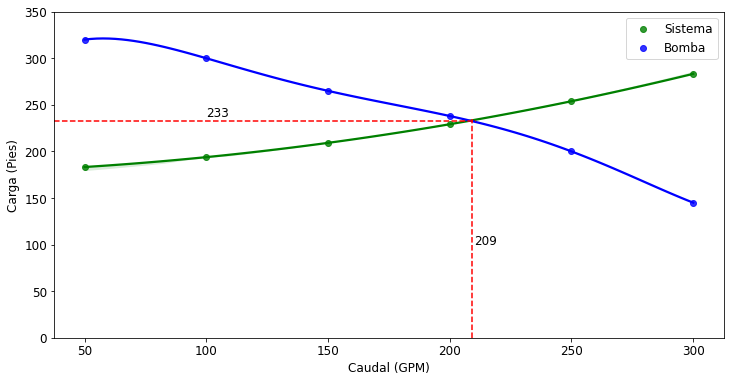

In [51]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.regplot(x = Alturas_bomba_sistema.index, y = Alturas_bomba_sistema.values, ax = ax, order = 2, label = "Sistema", color = "green")
sns.regplot(x = Alturas_bomba_6PWS230G150.index, y = Alturas_bomba_6PWS230G150.values, ax = ax, order = 5, ci = None, label = "Bomba", color = "blue")

ax.set_ylim([0, 350])

ax.axvline(x = 209, ymax = 0.67, color = "red", linestyle = "--")
ax.text(209+1, 100, '209', fontsize = 12)

ax.axhline(y = 233, xmax = 0.63, color = 'red', linestyle = "--")
ax.text(100, 233+5, '233', fontsize = 12)

ax.tick_params(labelsize = 12)

ax.set_xlabel("Caudal (GPM)", fontsize = 12)
ax.set_ylabel("Carga (Pies)", fontsize = 12)

ax.legend(loc = "best", prop = {'size': 12})

plt.savefig('Figura 60.png')

In [52]:
h_bomba = 233*0.3048
print(f"Carga total de la bomba en el punto de operación = {h_bomba:.3f} m")

Caudal_bomba = 209*6.30901964e-5
print(f"Caudal de la bomba en el punto de operación = {Caudal_bomba:.3f} m3/s")

Carga total de la bomba en el punto de operación = 71.018 m
Caudal de la bomba en el punto de operación = 0.013 m3/s


In [53]:
W_dot_bomba = rho * g * h_bomba * Caudal_bomba/1000
print(f"Potencia de la bomba en el punto de operación = {W_dot_bomba:.3f} kW")

Potencia de la bomba en el punto de operación = 9.168 kW


In [54]:
eta_mb = 0.72 #Eficiencia de la electrobomba según catálogo de bomba en el punto de operación.

W_dot_motor = W_dot_bomba/eta_mb
print(f"Potencia eléctrica del motor = {W_dot_motor:.3f} kW")

Potencia eléctrica del motor = 12.733 kW


In [55]:
P_a = 101.325 * 1000 #Presión en el punto a [Pa].
Z_e = 105.665 #Cota del punto e [msnm].
h_L_aYe = 0 #Pérdida de carga entre los puntos a y e.

h_estancamiento_e = P_a/(rho*g) + (v_a**2)/(2*g) + Z_a - Z_e - h_L_aYe
print(f"Carga de presión de estancamiento en la entrada de la bomba = {h_estancamiento_e:.3f} m")

Carga de presión de estancamiento en la entrada de la bomba = 12.684 m


In [56]:
P_vapor = 2.34 #Presión de vapor del agua a 20 °C [kPa].
NPSH_dis = h_estancamiento_e - P_vapor*1000/(rho*g)
print(f"NPSH disponible en la instalación = {NPSH_dis:.3f} m")
print(f"NPSH disponible en la instalación = {NPSH_dis/0.3048:.3f} pies")

NPSH disponible en la instalación = 12.445 m
NPSH disponible en la instalación = 40.831 pies


In [57]:
NPSH_req = 9.375 #Valor obtenido del catálogo del fabricante de la bomba bajo el caudal de operación [pies].

NPSH_dis/0.3048 > 1.1 * NPSH_req

True

#### La relación anterior resulta ser True, lo que verifica que no habrá problemas de cavitación bajo el caudal de operación.

In [58]:
R = 0.7 #Rendimiento de la instalación fotovoltaica.
W_dot_generador = W_dot_motor/R
print(f"Potencia del generador fotovoltaico = {W_dot_generador:.3f} kW")

Potencia del generador fotovoltaico = 18.191 kW


In [59]:
NOCT = 45 #Temperatura de operación nominal de la célula solar del panel seleccionado [°C].
T_amb = 24.100 #Temperatura ambiente [°C].
H = 1000 #Irradiancia [W/m2].
T_cel = ceil(T_amb + (NOCT - 20)*H/800)
print(f"Temperatura de la célula solar = {T_cel} °C")

Temperatura de la célula solar = 56 °C


In [60]:
CT_W_dot_mpp = -0.57402 #Coeficiente potencia-temperatura [%].
CT_V_oc = -0.38038 #Coeficiente voltaje-temperatura [%].
CT_I_sc = 0.02973 #Coeficiente corriente-temperatura [%].
T_test = 25 #Temperatura de ensayo de los paneles seleccionados [°C].

Cambio_W_dot_mpp = CT_W_dot_mpp * (T_cel - T_test)
print(f"Cambio en la potencia pico = {Cambio_W_dot_mpp:.3f} %")

Cambio_V_oc = CT_V_oc * (T_cel - T_test)
print(f"Cambio en el voltaje de circuito abierto = {Cambio_V_oc:.3f} %")

Cambio_I_sc = CT_I_sc * (T_cel - T_test)
print(f"Cambio en la corriente de cortocircuito = {Cambio_I_sc:.3f} %")

Cambio en la potencia pico = -17.795 %
Cambio en el voltaje de circuito abierto = -11.792 %
Cambio en la corriente de cortocircuito = 0.922 %


In [61]:
W_dot_mpp = 370 #potencia pico [W].
V_oc = 48.3 #Voltaje en circuito abierto [V].
I_sc = 9.95 #Corriente de cortocircuito [A].

W_dot_mpp_corr = W_dot_mpp * (1 + Cambio_W_dot_mpp/100)
V_oc_corr = V_oc * (1 + Cambio_V_oc/100)
I_sc_corr = I_sc * (1 + Cambio_I_sc/100)

print(f"Potencia pico corregida por la temperatura de la célula = {W_dot_mpp_corr:.3f} W")
print(f"Voltaje en circuito abierto corregida por la temperatura de la célula = {V_oc_corr:.3f} V")
print(f"Corriente de cortocircuito corregida por la temperatura de la célula = {I_sc_corr:.3f} A")

Potencia pico corregida por la temperatura de la célula = 304.160 W
Voltaje en circuito abierto corregida por la temperatura de la célula = 42.605 V
Corriente de cortocircuito corregida por la temperatura de la célula = 10.042 A


In [62]:
N_pan = W_dot_generador*1000/W_dot_mpp_corr
print(f"Número de paneles del generador fotovoltaico = {N_pan:.3f}")

Número de paneles del generador fotovoltaico = 59.806


#### Se elige 60 paneles solares ya que como se verá a continuación, este número es divisible por la cantidad de paneles en serie que hay en cada cadena del generador fotovoltaico.

In [63]:
N_pan = 60 #Número total de paneles solares seleccionados.

V_nom_sf = 800 #Voltaje nominal del sistema fotovoltaico adecuado para el inversor de bombeo solar [V].
V_mpp = 40.1 #Voltaje en el punto de máxima potencia [V].

N_pan_ser = V_nom_sf/V_mpp
print(f"Número de paneles en serie = {N_pan_ser:.3f}")

Número de paneles en serie = 19.950


#### Se toma 20 paneles en serie por cadena.

In [64]:
N_pan_ser = 20 #Número de paneles en serie.

N_cad_par = N_pan/N_pan_ser
print(f"Número de cadenas en paralelo = {N_cad_par}")

Número de cadenas en paralelo = 3.0


In [65]:
fs = 1.1 #Factor de seguridad.
W_dot_inv = W_dot_motor * fs
print(f"Potencia del inversor de bombeo solar = {W_dot_inv:.3f} kW")

Potencia del inversor de bombeo solar = 14.007 kW


In [66]:
V_max_inv = V_mpp * N_pan_ser
print(f"Voltaje que el inversor debe soportar en su entrada como mínimo = {V_max_inv:.3f} V")

Voltaje que el inversor debe soportar en su entrada como mínimo = 802.000 V


In [67]:
fs = 1.1 #Factor de seguridad
I_max_inv = fs * I_sc_corr * N_cad_par
print(f"Corriente que el inversor debe soportar en su entrada como mínimo = {I_max_inv:.3f} A")

Corriente que el inversor debe soportar en su entrada como mínimo = 33.138 A
